# Import

In [474]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import ticker

# Variables

In [475]:

# skgo
# TODO(EASY):
    # fix units of measure, names, labels ... in graphs
# TODO(MEDIUM):
    # double fits
# TODO(HARD):
    # NOTHING, I already took care of the clusterfuck for Chi-squared maps


wp = 1.37*10**16  #[Hz]
vf = 1.40*10**15  #[nm/s]
Gamma_bulk = 0.476*10**14  #[Hz] # from Ashcroft-Mermin (at 100°C)
c = 299792458*10**9 # [nm/s]
z = 10**7 # [nm]
# guesses of beest fit values from chi-squared maps: use those as initial guesses for the size dependent fits
epsilonm_guess = 2.3
rho_guess = 3.5*10**-9
R_guess = 5
epsilonm_fit = epsilonm_guess
rho_fit = rho_guess
R_fit = R_guess

bulk_data = pd.read_csv("bulk gold dieletric functions.txt", sep="\t", header=None)
bulk_data.columns = ["lambda", "epsilon1", "epsilon2"]
epsilon1_bulk = np.array(bulk_data["epsilon1"]) # from 200nm to 900nm
epsilon2_bulk = np.array(bulk_data["epsilon2"]) # from 200nm to 900nm

np_data = pd.read_csv("G01-NPs.dat", sep="\t", header=None)
np_data.columns = ["lambda", "absorbance"]
absorbance = np.array(np_data["absorbance"])
absorbance_r = absorbance[50:201]  # _r variables are restricted to the selected fit region # I've also tried [70:171]

l = np.array(np_data["lambda"])  # from 400nm to 800nm
l_bulk = np.array(bulk_data["lambda"]) # from 200nm to 900nm
l_r = l[50:201]

# FUNCTION DEFINITIONS

In [476]:
def Gamma(R): # [Hz]
    return Gamma_bulk * (1+(np.pi*vf/(4*Gamma_bulk*R)))

def omega(l):  #[Hz]
    return 2*np.pi*c/l

def epsilon1(l, R):
    l=l.astype(int)-200
    try:
        e1 = epsilon1_bulk[l]+wp**2 * (1/(omega(l)**2+Gamma_bulk**2)-1/(omega(l)**2+Gamma(R)**2))
        return e1
    except:
        print("Invalid wavelength")
          
def epsilon2(l, R):
    l=l.astype(int)-200
    try:
        e2 = epsilon2_bulk[l]-wp**2/omega(l) * (Gamma_bulk/(omega(l)**2+Gamma_bulk**2)-Gamma(R)/(omega(l)**2+Gamma(R)**2))
        return e2
    except:
        print("Invalid wavelength")

def Absorbance(l, R, epsilonm, rho): # rho = [nm**(-3)]
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*4/3*np.pi*R**3*rho*epsilon2(l, R)/((epsilon1(l, R)+2*epsilonm)**2+(epsilon2(l, R))**2)

def Absorbance_f(l, R, epsilonm, f):
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*f*epsilon2(l, R)/((epsilon1(l, R)+2*epsilonm)**2+(epsilon2(l, R))**2)

def Absorbance_epsilonmfix(l, R, rho):
    return Absorbance(l, R, epsilonm_guess, rho)

def Absorbance_JC(l, epsilonm, f):
    l=l.astype(int)-200
    return np.log10(np.e)*9*z*omega(l)/c*epsilonm**(3/2)*f*epsilon2_bulk[l]/((epsilon1_bulk[l]+2*epsilonm)**2+(epsilon2_bulk[l])**2)

def Chi(observed, expected):
    return ((observed-expected)**2/expected).sum()

def Chi_R_rho(R, rho):
    return Chi(absorbance_r, Absorbance(l_r, R, epsilonm_guess, rho))

def Chi_R_epsilonm(R, epsilonm): # only accounts for the chi squared in the selected fit range
    return Chi(absorbance_r, Absorbance(l_r, R, epsilonm, rho_fit))

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)

#  FITTING: Johnson and Christy

In [477]:
par_fit_JC, par_cov_JC = curve_fit(Absorbance_JC, l, absorbance, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted = Absorbance_JC(l, epsilonm=par_fit_JC[0], f=par_fit_JC[1])

par_fit_JC_r, par_cov_JC_r = curve_fit(Absorbance_JC, l_r, absorbance_r, p0=(epsilonm_guess, 2*10**-6))
Absorbance_JC_fitted_r = Absorbance_JC(l, epsilonm=par_fit_JC_r[0], f=par_fit_JC_r[1])

with open("outputfile.txt", "w") as outfile:
    multiwrite(outfile, "Full curve JC fit:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC[0]) + " with error " + str(np.sqrt(par_cov_JC[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC[1]) + " with error " + str(np.sqrt(par_cov_JC[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted)))
    multiwrite(outfile, "")
    
    multiwrite(outfile, "Restricting the JC fit to 470nm-570nm:")
    multiwrite(outfile, "espilonm_JC = " + str(par_fit_JC_r[0]) + " with error " + str(np.sqrt(par_cov_JC_r[0,0])))
    multiwrite(outfile, "f_JC = " + str(par_fit_JC_r[1]) + " with error " + str(np.sqrt(par_cov_JC_r[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_JC_fitted_r)))
    multiwrite(outfile, "")

Full curve JC fit:
espilonm_JC = 2.3332225378831177 with error 0.02154811267205331
f_JC = 8.220511279213427e-07 with error 1.4735382995249881e-08
Chi-squared = 36.23919803763101

Restricting the JC fit to 470nm-570nm:
espilonm_JC = 2.296952133299161 with error 0.03092277392338673
f_JC = 8.41099100108054e-07 with error 2.3658786847627182e-08
Chi-squared = 37.51093164516652



#  FITTING: Size dependent, initial triple fit

In [478]:
# Initial 3 parameter fit: this can give the initial guess for the more refined fit later, but results are not totally realiable
# Indeed rho*R**3 is constant, so the dependency on R and rho is very weak and there probably are a lot of local minima
par_fit, par_cov = curve_fit(Absorbance, l_r, absorbance_r, p0=(R_guess, epsilonm_guess, rho_guess))
Absorbance_fitted = Absorbance(l, R=par_fit[0], epsilonm=par_fit[1], rho=par_fit[2])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit[0]) + " nm, with error " + str(np.sqrt(par_cov[0,0])) + " nm")
    multiwrite(outfile, "espilonm = " + str(par_fit[1]) + " with error " + str(np.sqrt(par_cov[1,1])))
    multiwrite(outfile, "rho = " + str(par_fit[2]) + " nm**-3, with error " + str(np.sqrt(par_cov[2,2])) + " nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted)))
    multiwrite(outfile, "")


Fit restricted to 470nm-570nm:
R = 0.8172854088536675 nm, with error 0.02035573866055793 nm
espilonm = 2.059181169330377 with error 0.012778387727654486
rho = 9.051592989895188e-07 nm**-3, with error 7.65672504664653e-08 nm**-3
Chi-squared = 2.150133480797316



# FITTING: size dependet, double fits

In [479]:
#fixing epsilonm to our guess (assuming epsilonm=n^2 knowing we are in water)
par_fit_epsilonmfix, par_cov_epsilonmfix = curve_fit(Absorbance_epsilonmfix, l_r, absorbance_r, p0=(R_guess, rho_guess))
Absorbance_fitted_epsilonmfix = Absorbance_epsilonmfix(l, R=par_fit_epsilonmfix[0], rho=par_fit_epsilonmfix[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_epsilonmfix[0]) + " nm, with error " + str(np.sqrt(par_cov_epsilonmfix[0,0])) + " nm")
    multiwrite(outfile, "rho = " + str(par_fit_epsilonmfix[1]) + " nm**-3, with error " + str(np.sqrt(par_cov_epsilonmfix[1,1])) + " nm**-3")
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_epsilonmfix)))
    multiwrite(outfile, "")


#fixing rho to the one obtained previously
def Absorbance_rhofix(l, R, epsilonm):
    return Absorbance(l, R, epsilonm, par_fit_epsilonmfix[1])

par_fit_rhofix, par_cov_rhofix = curve_fit(Absorbance_rhofix, l_r, absorbance_r, p0=(R_guess, epsilonm_guess))
Absorbance_fitted_rhofix = Absorbance_rhofix(l, R=par_fit_rhofix[0], epsilonm=par_fit_rhofix[1])

with open("outputfile.txt", "a") as outfile:
    multiwrite(outfile, "Fit restricted to 470nm-570nm:")
    multiwrite(outfile, "R = " + str(par_fit_rhofix[0]) + " nm, with error " + str(np.sqrt(par_cov_rhofix[0,0])) + " nm")
    multiwrite(outfile, "epsilonm = " + str(par_fit_rhofix[1]) + " with error " + str(np.sqrt(par_cov_rhofix[1,1])))
    multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_rhofix)))
    multiwrite(outfile, "")


# fixing epsilonm to the previous value, si sperava migliorasse ma R passa da 1nm a 0.8nm
# def Absorbance_epsilonmfixfit(l, R, rho):
#     return Absorbance(l, R, par_fit_rhofix[1], rho)

# par_fit_epsilonmfixfit, par_cov_epsilonmfixfit = curve_fit(Absorbance_epsilonmfixfit, l_r, absorbance_r, p0=(R_guess, rho_guess))
# Absorbance_fitted_epsilonmfixfit = Absorbance_epsilonmfixfit(l, R=par_fit_epsilonmfixfit[0], rho=par_fit_epsilonmfixfit[1])

# with open("outputfile.txt", "a") as outfile:
#     multiwrite(outfile, "Fit restricted to 470nm-570nm:")
#     multiwrite(outfile, "R = " + str(par_fit_epsilonmfixfit[0]) + " nm, with error " + str(np.sqrt(par_cov_epsilonmfixfit[0,0])) + " nm")
#     multiwrite(outfile, "rho = " + str(par_fit_epsilonmfixfit[1]) + " nm**-3, with error " + str(np.sqrt(par_cov_epsilonmfixfit[1,1])) + " nm**-3")
#     multiwrite(outfile, "Chi-squared = " + str(Chi(absorbance, Absorbance_fitted_epsilonmfixfit)))
#     multiwrite(outfile, "")



#TODO:
    # do a fit fixing epsilonm to epsilonm_guess and find (R, rho) pair
        # note: this fit is probably going to give shit because R and rho are obviously correlated
        # so there's a curve of values that basically all give the same fit
        # really we should use the filling fraction, because that is what really matters, together with R
        # but we're asked to do it, so just do it and hope
        # possibly put some soundaries so that we don't get R<1nm (as in the triple fit)
        # if you have time and want to improve the results it might be a good idea to really use (R, f) pair, even if we weren't asked to do so
    # also do the (R, epsilonm) fit fixing rho either to rho_guess or to rho_fit (after updating it)
        # this will give no problems
    # update epsilonm_fit, ... values to the found values
    # do some plots of the results

Fit restricted to 470nm-570nm:
R = 1.005532878695399 nm, with error 0.045144001810449544 nm
rho = 3.9539382285639636e-07 nm**-3, with error 5.606216528199767e-08 nm**-3
Chi-squared = 1.4252618040273268

Fit restricted to 470nm-570nm:
R = 1.0458349407612264 nm, with error 0.0031623923630626507 nm
epsilonm = 2.126311625755263 with error 0.011517345644883282
Chi-squared = 0.9652399397829003



# FITTING: Chi squared maps

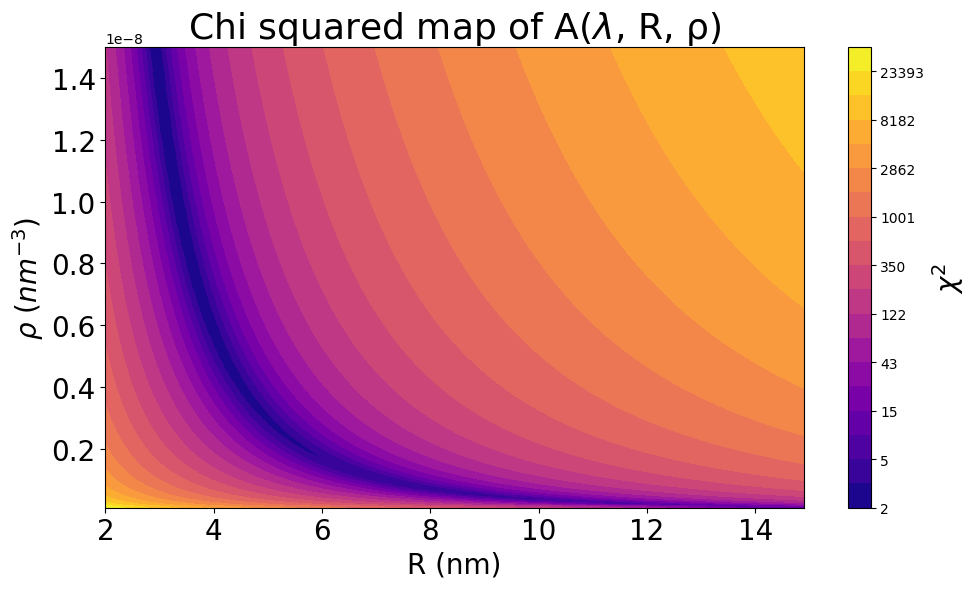

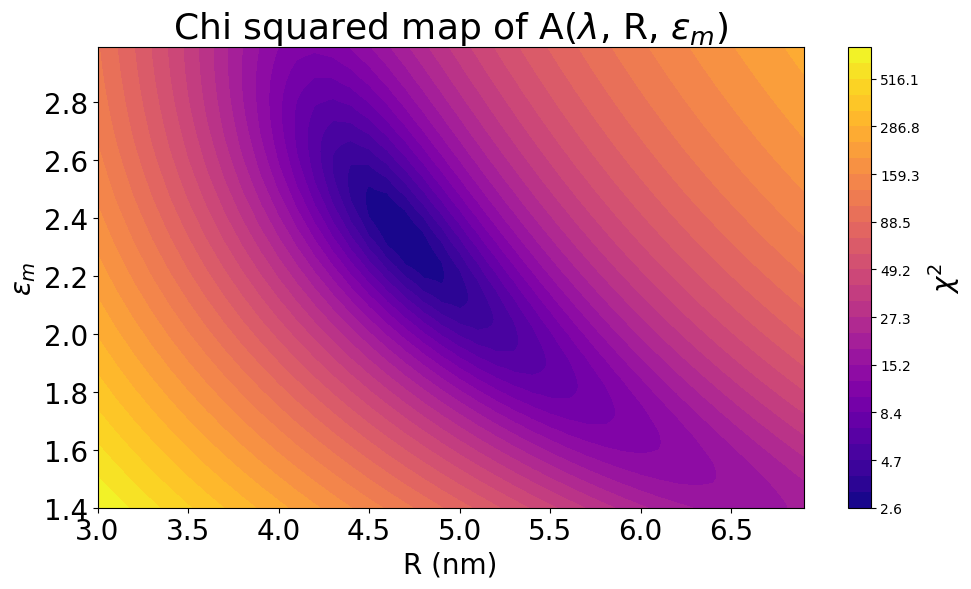

In [480]:
R_domain_1 = np.arange(2, 15, 0.1)
rho_domain = np.arange(1*10**-10, 15*10**-9, 10**-10)
epsilonm_domain = np.arange(1.4, 3, 0.01)
R_domain_2 = np.arange(3, 7, 0.1)

Chi_R_rho_values = np.zeros((len(R_domain_1), len(rho_domain)))    
for i in range(len(R_domain_1)):
    for j in range(len(rho_domain)):
        Chi_R_rho_values[i, j] = Chi_R_rho(R_domain_1[i], rho_domain[j])
        
plt.figure(figsize=(10, 6), dpi=100)
contour_plot = plt.contourf(R_domain, rho_domain, Chi_R_rho_values.transpose(),
                            np.logspace(np.log10(Chi_R_rho_values.min()), np.log10(Chi_R_rho_values.max()), 20), locator=ticker.LogLocator(), cmap="plasma")
plt.colorbar().set_label(label=r"$\chi^2$",size=20)
#plt.colorbar().ax.tick_params(labelsize=20) #lol perchè ne crea una nuova con la dimensione giusta invece che cambiarla a quella vecchia
plt.title("Chi squared map of A($\lambda$, R, ρ)", fontsize=26)
plt.xlabel("R (nm)", fontdict={"fontsize": 20})
plt.xticks(fontsize=20)
plt.ylabel(r"$\rho \ (nm^{-3})$", fontdict={"fontsize": 20})
plt.yticks(fontsize=20)
#plt.yaxis.get_offset_text.set_fontsize(20) #triste tentativo di ingrandire l'esponente sull'asse y
plt.tight_layout()


Chi_R_epsilonm_values = np.zeros((len(R_domain_2), len(epsilonm_domain)))
for i in range(len(R_domain_2)):
    for j in range(len(epsilonm_domain)):
        Chi_R_epsilonm_values[i, j] = Chi_R_epsilonm(R_domain_2[i], epsilonm_domain[j])
        
plt.figure(figsize=(10, 6), dpi=100)
contour_plot = plt.contourf(R_domain_2, epsilonm_domain, Chi_R_epsilonm_values.transpose(),
                            np.logspace(np.log10(Chi_R_epsilonm_values.min()), np.log10(Chi_R_epsilonm_values.max()), 30),
                            locator=ticker.LogLocator(), cmap="plasma")
plt.colorbar().set_label(label=r"$\chi^2$",size=20)
#plt.colorbar().ax.tick_params(labelsize=20) #lol perchè ne crea una nuova con la dimensione giusta invece che cambiarla a quella vecchia
plt.title("Chi squared map of A($\lambda$, R, $\epsilon_m$)", fontsize=26)
plt.xlabel("R (nm)", fontdict={"fontsize": 20})
plt.xticks(fontsize=20)
plt.ylabel(r"$\epsilon_m$", fontdict={"fontsize": 20})
plt.yticks(fontsize=20)
plt.tight_layout()

#non so bene la differenza fra le due, il titolo è da correggere così diventa chiaro

# PLOTTING

In [481]:
# Bulk gold dielectric functions
# plt.figure(figsize=(10, 6), dpi=100)
# plt.plot(l_bulk, epsilon1_bulk, color="green", label=r"$\epsilon_1$")
# plt.plot(l_bulk, epsilon2_bulk, color="red", label=r"$\epsilon_2$")
# plt.title("Bulk gold dielectric functions", fontdict={"fontname": "Calibri", "fontsize": 20})
# plt.xlabel(r"$\lambda$", fontdict={"fontsize": 14})
# plt.ylabel(r"$\epsilon$", fontdict={"fontsize": 14})
# plt.legend(fontsize=10, ncol=2)
# plt.tight_layout()

# JC plots
# plt.figure(figsize=(10, 6), dpi=100)
# plt.plot(l, absorbance, color="green", label=r"$\epsilon_1$")
# plt.plot(l, Absorbance_JC_fitted, color="blue", label=r"$\epsilon_1$")
# plt.plot(l, Absorbance_JC_fitted_r, color="red", label=r"$\epsilon_1$")
# plt.title("Absorbance", fontdict={"fontname": "Calibri", "fontsize": 20})
# plt.xlabel(r"$\lambda$", fontdict={"fontsize": 14})
# plt.ylabel(r"$\epsilon$", fontdict={"fontsize": 14})
# plt.legend(fontsize=10, ncol=2)
# plt.tight_layout()

#  PLOTTING: Size dependent, initial triple fit

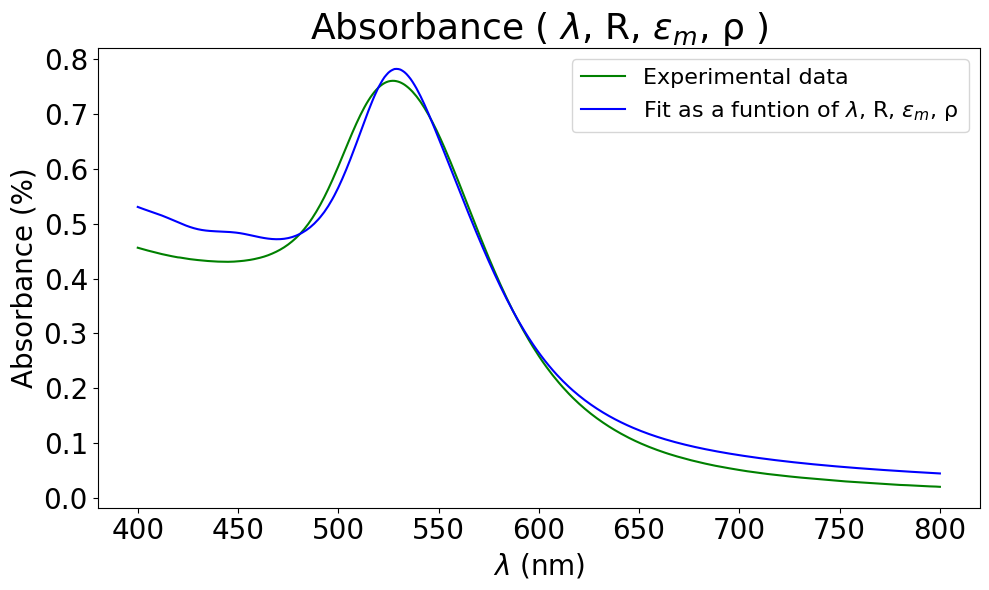

In [482]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted, color="blue", label="Fit as a funtion of $\lambda$, R, $\epsilon_{m}$, ρ ")
plt.title("Absorbance ( $\lambda$, R, $\epsilon_{m}$, ρ )", fontsize=26)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": 20})
plt.xticks(fontsize=20)
plt.ylabel("Absorbance (%)", fontdict={"fontsize": 20})
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()

# PLOTTING: size dependet, double fits

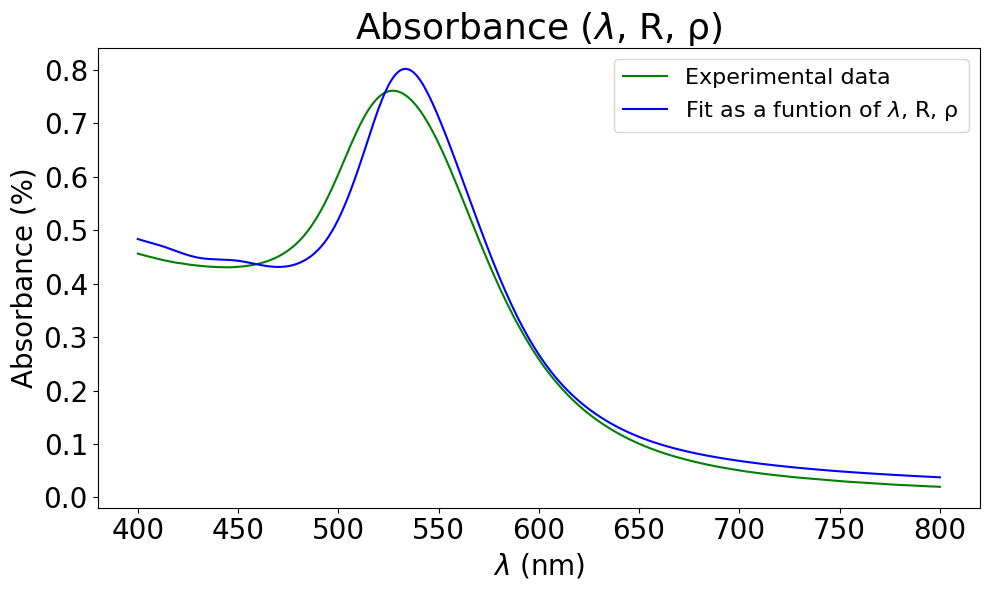

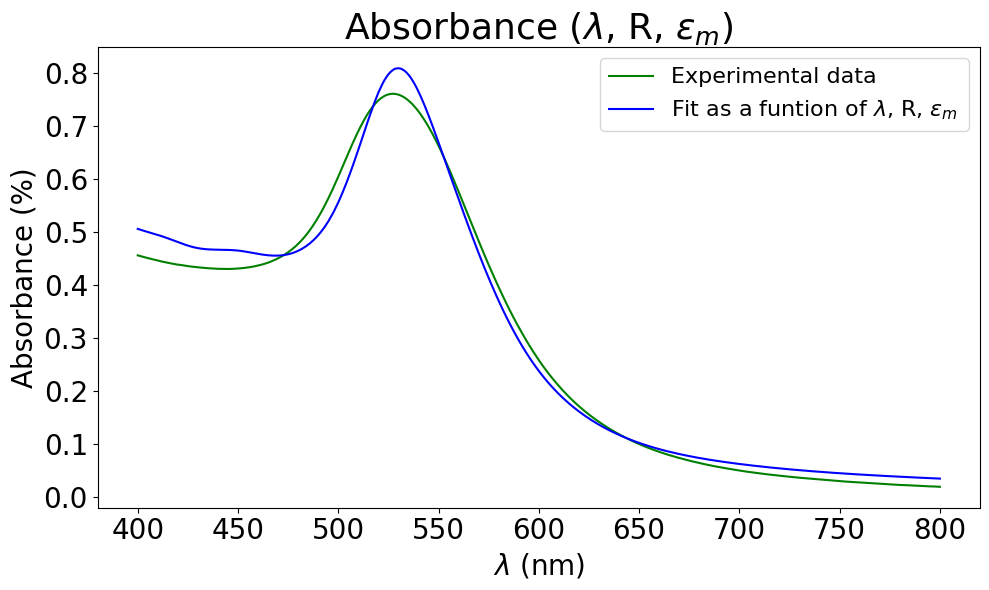

In [483]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_epsilonmfix, color="blue", label="Fit as a funtion of $\lambda$, R, ρ ")
plt.title("Absorbance ($\lambda$, R, ρ)", fontsize=26)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": 20})
plt.xticks(fontsize=20)
plt.ylabel("Absorbance (%)", fontdict={"fontsize": 20})
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()



plt.figure(figsize=(10, 6), dpi=100)
plt.plot(l, absorbance, color="green", label="Experimental data")
plt.plot(l, Absorbance_fitted_rhofix, color="blue", label="Fit as a funtion of $\lambda$, R, $\epsilon_{m}$ ")
plt.title("Absorbance ($\lambda$, R, $\epsilon_{m}$)", fontsize=26)
plt.xlabel(r"$\lambda$ (nm)", fontdict={"fontsize": 20})
plt.xticks(fontsize=20)
plt.ylabel("Absorbance (%)", fontdict={"fontsize": 20})
plt.yticks(fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
